In [ ]:
!pip install optuna
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna
import sweetviz as sv

from sklearn import metrics
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import tree
from sklearn import feature_selection

In [ ]:
gender = pd.read_csv('gender_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train['sample'] = 1
test['sample'] = 0

In [ ]:
df = pd.concat([train,test],axis=0,join='outer',ignore_index=True)

In [ ]:
report = sv.analyze(df)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


Data research

In [ ]:
s_per_class = train.pivot_table(values='PassengerId',index='Survived',columns='Pclass',aggfunc='count')
s_per_class

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


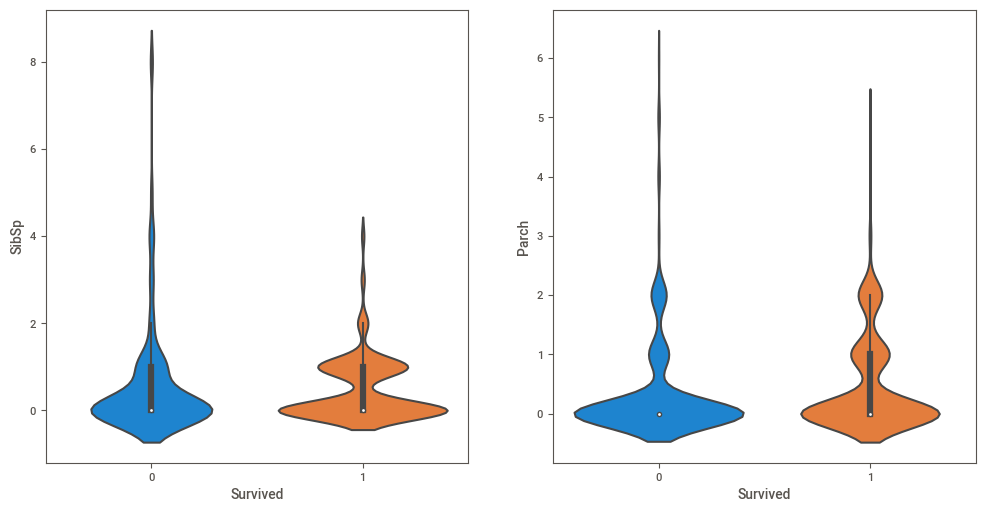

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.violinplot(data=train,x='Survived',y='SibSp',orient='v',ax=ax[0])
sns.violinplot(data=train,x='Survived',y='Parch',ax=ax[1])

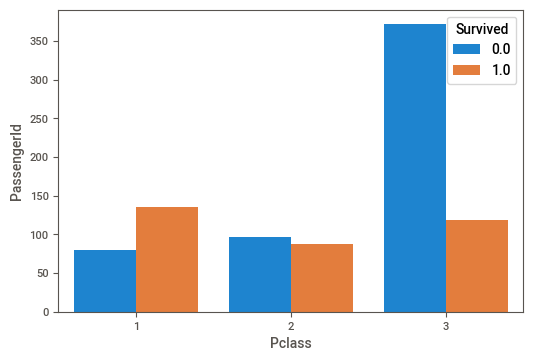

In [ ]:
s_per_class = df.groupby(['Survived','Pclass'])['PassengerId'].count()
s_per_class = s_per_class.reset_index()
sns.barplot(data=s_per_class,x='Pclass',y='PassengerId',hue='Survived')

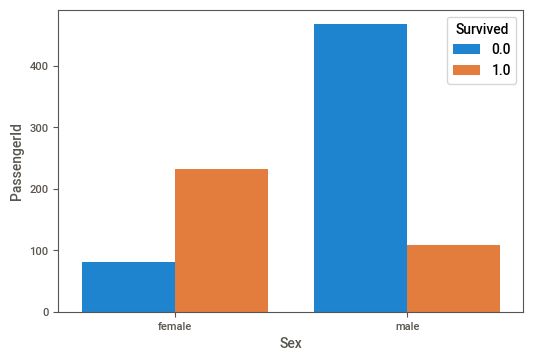

In [ ]:
s_per_sex = df.groupby(['Survived','Sex'])['PassengerId'].count()
s_per_sex = s_per_sex.reset_index()
sns.barplot(data=s_per_sex,x='Sex',y='PassengerId',hue='Survived')

In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'sample'],
      dtype='object')

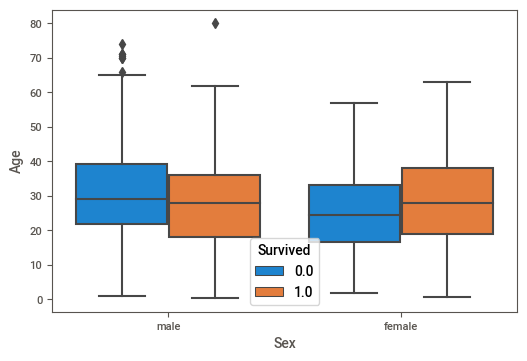

In [ ]:
sns.boxplot(data=df,x='Sex',y='Age',hue='Survived')

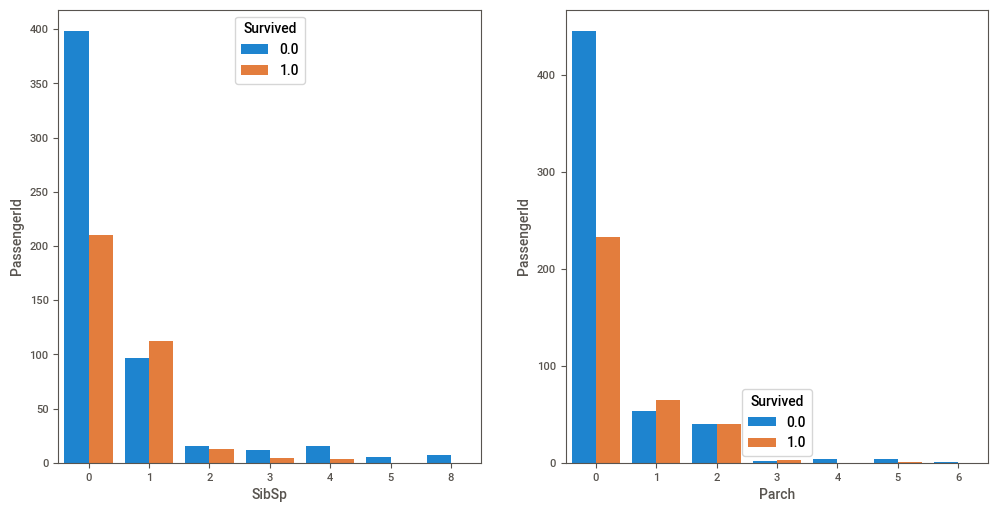

In [ ]:
s_per_sib_sp = df.groupby(['Survived','SibSp'])['PassengerId'].count()
s_per_sib_sp = s_per_sib_sp.reset_index()
s_per_parch = df.groupby(['Survived','Parch'])['PassengerId'].count()
s_per_parch = s_per_parch.reset_index()
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.barplot(data=s_per_sib_sp,x='SibSp',y='PassengerId',hue='Survived',ax=ax[0])
sns.barplot(data=s_per_parch,x='Parch',y='PassengerId',hue='Survived',ax=ax[1])

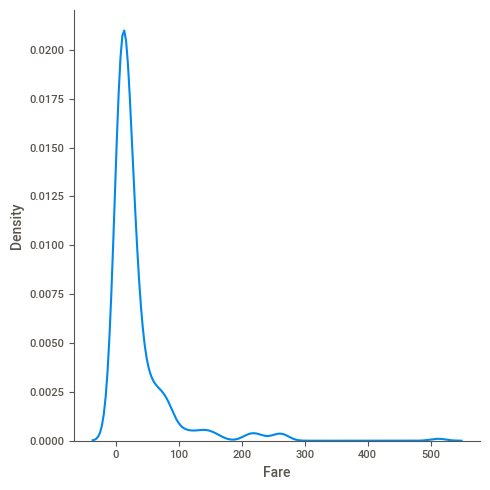

In [ ]:
sns.displot(df,x='Fare',kind='kde')

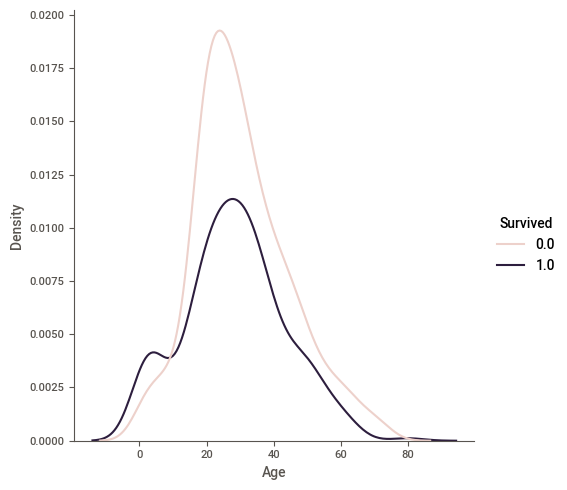

In [ ]:
sns.displot(df,x='Age',kind='kde',hue='Survived')

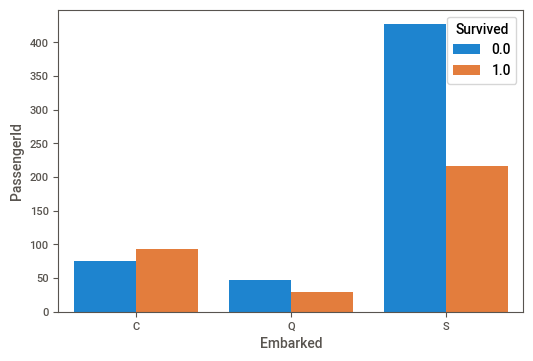

In [ ]:
s_per_emb = df.groupby(['Survived','Embarked'])['PassengerId'].count()
s_per_emb = s_per_emb.reset_index()
sns.barplot(data=s_per_emb,x='Embarked',y='PassengerId',hue='Survived')

EDA

In [ ]:
for i in df.columns:
  print(df[i].isna().value_counts())

False    1309
Name: PassengerId, dtype: int64
False    891
True     418
Name: Survived, dtype: int64
False    1309
Name: Pclass, dtype: int64
False    1309
Name: Name, dtype: int64
False    1309
Name: Sex, dtype: int64
False    1046
True      263
Name: Age, dtype: int64
False    1309
Name: SibSp, dtype: int64
False    1309
Name: Parch, dtype: int64
False    1309
Name: Ticket, dtype: int64
False    1308
True        1
Name: Fare, dtype: int64
True     1014
False     295
Name: Cabin, dtype: int64
False    1307
True        2
Name: Embarked, dtype: int64
False    1309
Name: sample, dtype: int64


In [ ]:
df.shape

(1309, 13)

In [ ]:
df['Age'] = df['Age'].fillna(value=df['Age'].mean())

In [ ]:
df['Embarked'] = df['Embarked'].fillna(value=df['Embarked'].mode().iloc[0])

In [ ]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
df.drop(['Cabin','Name','Ticket'],axis=1,inplace=True)

In [ ]:
df['Fare'] = df['Fare'].fillna(value=df['Fare'].mean())

FEATURE ENGINEERING

In [ ]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x=='male' else 0)
df['Sex'].value_counts()

1    843
0    466
Name: Sex, dtype: int64

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,sample
0,1,0.0,3,1,22.0,1,0,7.2500,S,1
1,2,1.0,1,0,38.0,1,0,71.2833,C,1
2,3,1.0,3,0,26.0,0,0,7.9250,S,1
3,4,1.0,1,0,35.0,1,0,53.1000,S,1
4,5,0.0,3,1,35.0,0,0,8.0500,S,1


In [ ]:
df['age_group'] = pd.cut(
    x=df['Age'],
    bins=[0,20,40,60,80],
    labels=['<20','20-40','40-60','60-80']
    )

In [ ]:
df['family'] = df.SibSp+df.Parch
df.drop(['SibSp','Parch'],axis=1,inplace=True)

In [ ]:
onehot = preprocessing.OneHotEncoder(sparse=False)
age = onehot.fit_transform(df[['age_group','Embarked']])
columns = onehot.get_feature_names_out()
hotted = pd.DataFrame(data=age,columns=columns)
df = pd.concat([df,hotted],join='outer',axis=1)

In [ ]:
df.drop(['Embarked','age_group','Age'],axis=1,inplace=True)

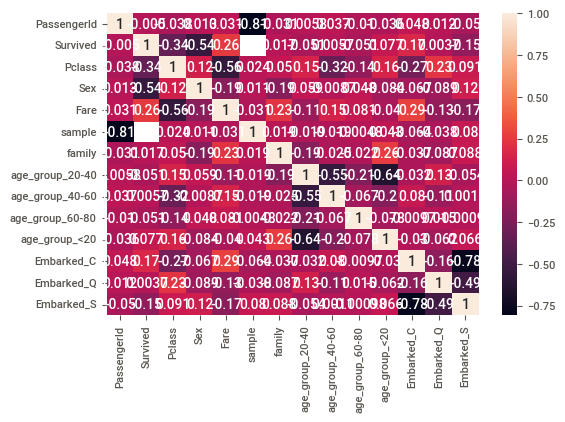

In [ ]:
sns.heatmap(df.corr(),annot=True)

In [ ]:
mmsc = preprocessing.MinMaxScaler()
fa = mmsc.fit_transform((df['Fare'].to_numpy()).reshape(-1,1))
df['Fare'] = fa

In [ ]:
train = df[df['sample']==1]
test = df[df['sample']==0]
train.drop('sample',axis=1,inplace=True)
test.drop('sample',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
mtx = (train.drop('PassengerId',axis=1)).corr().to_numpy()
np.linalg.det(mtx)

-1.0826253778026285e-31

In [ ]:
X = train.drop(['Survived','PassengerId'],axis=1)
y = train['Survived']

In [ ]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(712, 11) (179, 11) (712,) (179,)


In [ ]:
selector = feature_selection.SelectKBest()
selector.fit(X_train,y_train)
topten = list(selector.get_feature_names_out())
topten

['Pclass',
 'Sex',
 'Fare',
 'age_group_20-40',
 'age_group_40-60',
 'age_group_60-80',
 'age_group_<20',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [ ]:
clssi = ensemble.RandomForestClassifier(
    n_estimators=80,
    max_depth=12,
    n_jobs=-1,
    random_state=42,
    )
clssi.fit(X_train,y_train)
res_train = clssi.predict(X_train)
res_test = clssi.predict(X_test)
print(metrics.accuracy_score(y_train,res_train))
print(metrics.accuracy_score(y_test,res_test))

0.9396067415730337
0.8212290502793296


In [ ]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_split=3,
    min_samples_leaf=6,
    random_state=42
)
dt.fit(X_train,y_train)
res_train = dt.predict(X_train)
res_test = dt.predict(X_test)
print(metrics.accuracy_score(y_train,res_train))
print(metrics.accuracy_score(y_test,res_test))

0.8595505617977528
0.8156424581005587


In [ ]:
lr = linear_model.LogisticRegression(random_state=42)

In [ ]:
def optuna_gbc(trial):
  #loss=trial.suggest_categorical('loss',['log_loss','deviance'])
  #learning_rate=trial.suggest_float('learning_rate',1e-1,1,5e-2)
  n_estimators=trial.suggest_int('n_estimators',50,250,10)
  min_samples_split=trial.suggest_int('min_samples',2,5,1)
  min_samples_leaf=trial.suggest_int('min_samples_leaf',1,5,1)
  max_depth=trial.suggest_int('max_depth',5,20,1)
  random_state=42

  gbc = ensemble.GradientBoostingClassifier(
      #loss=loss,
      #learning_rate=learning_rate,
      n_estimators=n_estimators,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      max_depth=max_depth,
      random_state=random_state
  )

  gbc.fit(X_train,y_train)
  return gbc.score(X_test,y_test)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(optuna_gbc,n_trials=50)

[I 2022-10-08 19:15:24,528] A new study created in memory with name: no-name-158a544b-4036-4f2c-8633-d13c5a3e7292
[I 2022-10-08 19:15:25,642] Trial 0 finished with value: 0.776536312849162 and parameters: {'n_estimators': 220, 'min_samples': 4, 'min_samples_leaf': 1, 'max_depth': 12}. Best is trial 0 with value: 0.776536312849162.
[I 2022-10-08 19:15:26,231] Trial 1 finished with value: 0.7877094972067039 and parameters: {'n_estimators': 180, 'min_samples': 3, 'min_samples_leaf': 4, 'max_depth': 10}. Best is trial 1 with value: 0.7877094972067039.
[I 2022-10-08 19:15:27,424] Trial 2 finished with value: 0.7877094972067039 and parameters: {'n_estimators': 200, 'min_samples': 4, 'min_samples_leaf': 2, 'max_depth': 16}. Best is trial 1 with value: 0.7877094972067039.
[I 2022-10-08 19:15:28,705] Trial 3 finished with value: 0.7877094972067039 and parameters: {'n_estimators': 220, 'min_samples': 3, 'min_samples_leaf': 1, 'max_depth': 15}. Best is trial 1 with value: 0.7877094972067039.
[I 2

In [ ]:
study.best_params

{'n_estimators': 250, 'min_samples': 3, 'min_samples_leaf': 3}

In [ ]:
gbc = ensemble.GradientBoostingClassifier(
    loss='deviance',
    learning_rate=0.1,
    n_estimators=250,
    min_samples_leaf=3,
    max_depth=7,
    init=lr,
    random_state=42
)
gbc.fit(X_train,y_train)
res_train = gbc.predict(X_train)
res_test = gbc.predict(X_test)
print(metrics.accuracy_score(y_train,res_train))
print(metrics.accuracy_score(y_test,res_test))

0.9424157303370787
0.7932960893854749


In [ ]:
submission = pd.DataFrame()
submission['PassengerId'] = test.PassengerId

In [ ]:
submission['Survived'] = dt.predict(test.drop(['PassengerId','Survived'],axis=1))

In [ ]:
submission['Survived'] = submission['Survived'].astype('int')

In [ ]:
submission.reset_index(inplace=True,drop=True)

In [ ]:
submission.to_csv('submission.csv',index=False)